### SWIN UNET

In [2]:
# # lanciare solamente la prima volta. Altrimenti aggiunge, senza errori, sempre lo stesso path (ridondanza)

import sys
sys.path.append("C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/")

from keras_vision_transformer import swin_layers
from keras_vision_transformer import transformer_layers
from keras_vision_transformer import utils

import numpy as np
from glob import glob
import os.path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, concatenate

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def swin_transformer_stack(X, stack_num, embed_dim, num_patch, num_heads, window_size, num_mlp, shift_window=True, name=''):
    # Turn-off dropouts
    mlp_drop_rate = 0 # Droupout after each MLP layer
    attn_drop_rate = 0 # Dropout after Swin-Attention
    proj_drop_rate = 0 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
    drop_path_rate = 0 # Drop-path within skip-connections
    
    if shift_window:
        shift_size = window_size // 2
    else:
        shift_size = 0
    
    for i in range(stack_num):
    
        if i % 2 == 0:
            shift_size_temp = 0
        else:
            shift_size_temp = shift_size

        X = swin_layers.SwinTransformerBlock(dim=embed_dim, 
                                             num_patch=num_patch, 
                                             num_heads=num_heads, 
                                             window_size=window_size, 
                                             shift_size=shift_size_temp, 
                                             num_mlp=num_mlp, 
                                             qkv_bias=qkv_bias, 
                                             qk_scale=qk_scale,
                                             mlp_drop=mlp_drop_rate, 
                                             attn_drop=attn_drop_rate, 
                                             proj_drop=proj_drop_rate, 
                                             drop_path_prob=drop_path_rate, 
                                             name='name{}'.format(i))(X)
    return X


def swin_unet_2d_base(input_tensor, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True, name='swin_unet'):
    
    # Compute number be patches to be embeded
    input_size = input_tensor.shape.as_list()[1:]
    num_patch_x = input_size[0]//patch_size[0]
    num_patch_y = input_size[1]//patch_size[1]
    
    # Number of Embedded dimensions
    embed_dim = filter_num_begin
    
    depth_ = depth
    
    X_skip = []

    X = input_tensor
    
    # Patch extraction
    X = transformer_layers.patch_extract(patch_size)(X)

    # Embed patches to tokens
    X = transformer_layers.patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)
    
    # The first Swin Transformer stack
    X = swin_transformer_stack(X, 
                               stack_num=stack_num_down, 
                               embed_dim=embed_dim, 
                               num_patch=(num_patch_x, num_patch_y), 
                               num_heads=num_heads[0], 
                               window_size=window_size[0], 
                               num_mlp=num_mlp, 
                               shift_window=shift_window, 
                               name='{}_swin_down0'.format(name))
    X_skip.append(X)
    
    # Downsampling blocks
    for i in range(depth_-1):
        
        # Patch merging
        X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)
        
        # update token shape info
        embed_dim = embed_dim*2
        num_patch_x = num_patch_x//2
        num_patch_y = num_patch_y//2
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_down, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i+1], 
                                   window_size=window_size[i+1], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_down{}'.format(name, i+1))
        
        # Store tensors for concat
        X_skip.append(X)
        
    # reverse indexing encoded tensors and hyperparams
    X_skip = X_skip[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]
    
    # upsampling begins at the deepest available tensor
    X = X_skip[0]
    
    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]
    
    depth_decode = len(X_decode)
    
    for i in range(depth_decode):
        
        # Patch expanding
        X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                               embed_dim=embed_dim, 
                                               upsample_rate=2, 
                                               return_vector=True)(X)
        

        # update token shape info
        embed_dim = embed_dim//2
        num_patch_x = num_patch_x*2
        num_patch_y = num_patch_y*2
        
        # Concatenation and linear projection
        X = concatenate([X, X_decode[i]], axis=-1, name='{}_concat_{}'.format(name, i))
        X = Dense(embed_dim, use_bias=False, name='{}_concat_linear_proj_{}'.format(name, i))(X)
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, 
                                   stack_num=stack_num_up, 
                                   embed_dim=embed_dim, 
                                   num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i], 
                                   window_size=window_size[i], 
                                   num_mlp=num_mlp, 
                                   shift_window=shift_window, 
                                   name='{}_swin_up{}'.format(name, i))
    
    X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                           embed_dim=embed_dim, 
                                           upsample_rate=patch_size[0], 
                                           return_vector=False)(X)    
    return X
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting tri-mask of {1, 2, 3} to three categories.'''
    return keras.utils.to_categorical(target_array)
def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, 
                   labelbottom=False, left=False, right=False, labelleft=False)
    return ax


In [4]:
filter_num_begin = 128     # channels
depth = 4                  # the depth of SwinUNET; 3+1 bottom level 
stack_num_down = 2         # downsampling
stack_num_up = 2           # upsampling
patch_size = (4, 4)        # patch 4x4
num_heads = [4, 8, 8, 8]   # the number of attention heads
window_size = [4, 2, 2, 2] # the size of attention window
num_mlp = 512              # number of MLP nodes within the Transformer
shift_window=True          # Apply window shifting (SW-MLP)

In [5]:
# Input section
input_size = (128,128,3)
IN = Input(input_size)

# Base architecture
X = swin_unet_2d_base(IN, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, 
                      shift_window=shift_window, name='swin_unet')
n_labels = 2
OUT = Conv2D(n_labels, kernel_size=1, use_bias=False, activation='softmax')(X)
model = Model(inputs=[IN,], outputs=[OUT,])
opt = keras.optimizers.Adam(learning_rate=1e-4, clipvalue=0.5)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt)

In [6]:
import glob
import cv2
import numpy as np
import os

path="C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/training_synapse/*.png"
path1="C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/labels/"

if not os.path.exists(path1):
    os.makedirs(path1)
for img in glob.glob(path):
    print(img)
    name=img.split('/')[8].split('\\')[1]
    print(name)
    n= cv2.imread(img)
    #n=np.round(n/255.0)
    gray = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
    gray=np.round(gray/255)

    cv2.imwrite(path1+name,gray)

C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/training_synapse\image.0001.png
image.0001.png
C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/training_synapse\image.0001_1.png
image.0001_1.png
C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/training_synapse\image.0001_10.png
image.0001_10.png
C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/training_synapse\image.0001_11.png
image.0001_11.png
C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/training_synapse\image.0001_12.png
image.0001_12.png
C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/training_synapse\image.0001_13.png
image.0001_13.png
C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/training_synapse\image.0001_14.png
image.0001_14.png
C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/training_synapse\image.0001_15.png
image.0001_15.png
C:/Users/ambur/OneDrive/Desktop/

In [8]:
sample_names = np.array(sorted(glob.glob("C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/training_synapse/*.png")))

label_names = np.array(sorted(glob.glob('C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/labels/*png')))

L = len(sample_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.8*L); L_valid = int(0.1*L); L_test = L - L_train - L_valid
ind_train = ind_all[:L_train]
ind_valid = ind_all[L_train:L_train+L_valid]
ind_test = ind_all[L_train+L_valid:]
print(ind_test)
print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, L_test))
valid_input = input_data_process(utils.image_to_array(sample_names[ind_valid], size=128, channel=3))
valid_target = target_data_process(utils.image_to_array(label_names[ind_valid], size=128, channel=1))
print(valid_target.shape)
test_input = input_data_process(utils.image_to_array(sample_names[ind_test], size=128, channel=3))

test_target = target_data_process(utils.image_to_array(label_names[ind_test], size=128, channel=1))
print(np.unique(test_target))

[ 829  634   28  673  926  701  744  470  293  572  945  475  693  487
  623  166  230  350  622  787  753  522  942  147  262  930  471  679
  960  793  337  207  505  943  257  454 1005  892  568  825  748  149
  924  205  584  735  478  675   61  821  579  647  167  723  110  120
 1003  195  409  874   44  261  635   54  805  994  796   25  260  670
  185  476  184  621  281  244  764  591  114  565  263  669  512  715
 1002  947  659  306  935  200  146  126  190  445  707  346  812  225
  779  999  865   35]
Training:validation:testing = 807:100:102
(100, 128, 128, 2)
[0. 1.]


In [9]:
len(label_names)

1009

In [1]:
N_epoch = 15 
N_batch = 24 
N_sample = 16 
tol = 0       
max_tol = 10 
min_del = 0 
for epoch in range(N_epoch):
    
    # initial loss record
    if epoch == 0:
        y_pred = model.predict([valid_input])
        record = np.mean(keras.losses.categorical_crossentropy(valid_target, y_pred))
        print('\tInitial loss = {}'.format(record))
    
    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_sample]
        
        # batch data formation
        ## augmentation is not applied
        train_input = input_data_process(
            utils.image_to_array(sample_names[ind_train][ind_train_shuffle], size=128, channel=3))
        train_target = target_data_process(
            utils.image_to_array(label_names[ind_train][ind_train_shuffle], size=128, channel=1))
        
        # train on batch
        loss_ = model.train_on_batch([train_input,], [train_target,])
    
        
    # epoch-end validation
    y_pred = model.predict([valid_input])
    record_temp = np.mean(keras.losses.categorical_crossentropy(valid_target, y_pred))
    # ** validation loss is not stored ** #
    
    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp; # update the loss record
        tol = 0; # refresh early stopping patience
        # ** model checkpoint is not stored ** #

    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue;

NameError: name 'model' is not defined

In [11]:
print(test_input.shape)
y_pred = model.predict([test_input,])
print(y_pred.shape)
print(test_target.shape)


print('Testing set cross-entropy loss = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_target, y_pred))))

acc = keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)
acc.update_state(test_target,y_pred)
print('Testing set Accuracy = ',acc.result().numpy())


(102, 128, 128, 3)
4/4 [==============================] - 7s 1s/step
(102, 128, 128, 2)
(102, 128, 128, 2)
Testing set cross-entropy loss = 0.11478216201066971
Testing set Accuracy =  0.95602655


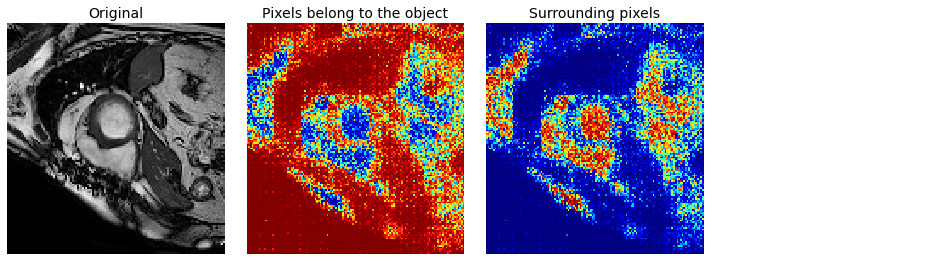

In [12]:
i_sample = 5
#i_sample = 0

fig, AX = plt.subplots(1, 4, figsize=(13, (13-0.2)/4))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(y_pred[i_sample, ..., 1], cmap=plt.cm.jet)
AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to the object", fontsize=14);
AX[2].set_title("Surrounding pixels", fontsize=14);

In [13]:
import cv2 
test_annotation_path = 'C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/labels/*.png'
test_image_path = 'C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/training_synapse/*png'
result_path = 'C:/Users/ambur/OneDrive/Desktop/FinalProject/II SwinUnet/Swin_images/result/viz'
label_names = np.array(sorted(glob.glob(test_annotation_path)))
sample_names = np.array(sorted(glob.glob(test_image_path)))
test_input_1 = input_data_process(utils.image_to_array(sample_names, size=128, channel=3))
test_target_1 = target_data_process(utils.image_to_array(label_names, size=128, channel=1))
y_pred_1 = (model.predict([test_input_1,]))

for i in range (len(label_names)):
    name=(os.path.basename(label_names[i]))
    cv2.imwrite(result_path+name,np.argmax(y_pred_1[i],axis=2)*255)
    

print('Testing set cross-entropy loss = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_target_1, y_pred_1))))
acc = keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)
acc.update_state(test_target_1,y_pred_1)
print('Testing set Accuracy = ',acc.result().numpy())

32/32 [==============================] - 68s 2s/step
Testing set cross-entropy loss = 0.11662313342094421
Testing set Accuracy =  0.9550025


In [14]:
test_input_1 = test_input
test_target_1 = test_target
y_pred_1 = (model.predict([test_input_1,]))

print('Testing set cross-entropy loss = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_target_1, y_pred_1))))
acc = keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)
acc.update_state(test_target_1,y_pred_1)
print('Testing set Accuracy = ',acc.result().numpy())

4/4 [==============================] - 8s 2s/step
Testing set cross-entropy loss = 0.11478216201066971
Testing set Accuracy =  0.95602655


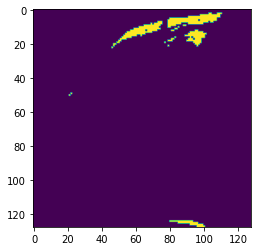

In [15]:
plt.imshow(np.argmax(test_target_1[0],axis=2)*255)
 

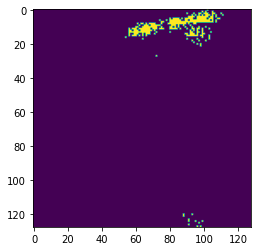

In [16]:
plt.imshow(np.argmax(y_pred_1[0],axis=2)*255)


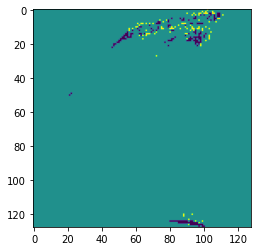

In [17]:
Error=np.argmax(y_pred_1[0],axis=2)*255-np.argmax(test_target_1[0],axis=2)*255
plt.imshow(Error)


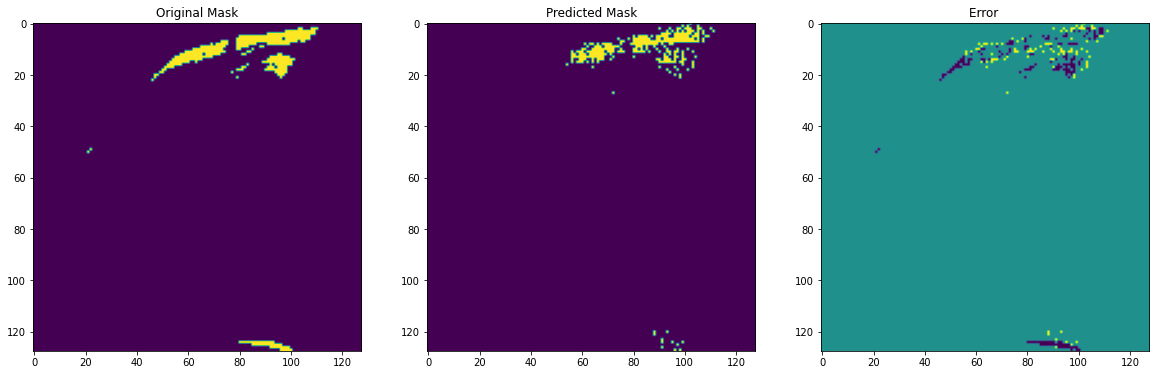

In [18]:
plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
plt.title("Original Mask")
plt.imshow(np.argmax(test_target_1[0],axis=2)*255)

plt.subplot(1,3,2)
plt.title('Predicted Mask')
plt.imshow(np.argmax(y_pred_1[0],axis=2)*255)

plt.subplot(1,3,3)
plt.title('Error ')
plt.imshow(np.argmax(y_pred_1[0],axis=2)*255-np.argmax(test_target_1[0],axis=2)*255);

In [19]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice   

mask1 = np.argmax(test_target_1[0],axis=2)
mask2 = np.argmax(y_pred_1[0],axis=2)

print(f"Dice Coefficient of two same masks are {DICE_COE(mask1, mask2)}")

Dice Coefficient of two same masks are 0.605
